This is a Soft Actor Critic (SAC) implementation.

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

import gymnasium as gym

import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

from model import ReplayBuffer

In [2]:
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)
        

class Actor(nn.Module):
    def __init__(self, env=None):
        super().__init__()
        self.input_dim = env.observation_space.shape[0]             
        self.output_dim = env.action_space.shape[0]
        
        self.l1 = nn.Linear(self.input_dim, 400)
        self.l2 = nn.Linear(400, 300)
        
        self.mu = nn.Linear(300, self.output_dim)
        self.std = nn.Linear(300, self.output_dim)
        
        self.apply(weights_init_)

    def forward(self, x):
        a = F.relu(self.l1(x))
        a = F.relu(self.l2(a))
        
        mu = self.mu(a)
        std = torch.clamp(F.softplus(self.std(a)), min=1e-6, max=5)
        return mu, std

    def sample(self, obs):
        mu, std = self(obs)
        n = Normal(mu, std)
        action = n.rsample().tanh()
        log_prob = (n.log_prob(action) - torch.log(1 - action.pow(2) + 1e-6)).sum(1)
        return action, log_prob


class Critic(nn.Module):
    def __init__(self, env=None):
        super().__init__()
        self.input_dim = env.observation_space.shape[0]             
        self.action_dim = env.action_space.shape[0]
        
        self.l1 = nn.Linear(self.input_dim + self.action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        
        self.apply(weights_init_)

    def forward(self, s, act):
        a = torch.hstack((s, act))
        a = F.relu(self.l1(a))
        a = F.relu(self.l2(a))
        a = self.l3(a)
        return a.squeeze()

In [3]:
env = gym.make("LunarLander-v2", continuous=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

actor = Actor(env).to(device)
Q1 = Critic(env).to(device)
Q2 = Critic(env).to(device)

Q1_ = Critic(env).to(device)
Q2_ = Critic(env).to(device)

Q1_.load_state_dict(Q1.state_dict())
Q2_.load_state_dict(Q2.state_dict())

optim_a = torch.optim.Adam(actor.parameters())
optim_q1 = torch.optim.Adam(Q1.parameters())
optim_q2 = torch.optim.Adam(Q2.parameters())

# Hyperparameters
gamma = 0.99
temp = 0.001     # Temperature of the entropy term
train_ep_freq = 1
num_opt_steps = 1

# Loggers
rews_log = []
steps_log = []

rb = ReplayBuffer(state_dim=env.observation_space.shape[0], 
                  action_dim=env.action_space.shape[0], 
                  length=1000000,
                  batch_size=256,
                  device=device)

In [4]:
def soft_update(target, source, tau=0.01):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(tau * source_param.data + 
                                (1.0 - tau) * target_param.data)

In [5]:
for episode in tqdm(range(1000)):    
    obs, _ = env.reset()
    done = False
    rews_ep = []
    step = 0
    
    # Play the game and collect data
    while not done:
        action = actor.sample(torch.tensor(obs).unsqueeze(0).to(device))[0]
        action = action[0].to('cpu').detach().numpy()
    
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        if not truncated:
            rb.store(obs, action, reward, obs_, terminated)
        obs = obs_
        
        rews_ep.append(reward)
        step += 1
    
    rews_log.append(sum(rews_ep) / len(rews_ep))
    steps_log.append(step)


    if episode % train_ep_freq == 0:
        for opt_step in range(num_opt_steps):
            s, a, r, s_, d = rb.sample()
            
            # Optimize the critics
            a_theta, log_prob = actor.sample(s_)
            q = torch.min(Q1_(s_, a_theta), Q2_(s_, a_theta)).to(device) 
            
            target = r + gamma * (1 - d) * (q - temp * log_prob)
            
            loss_q1 = F.mse_loss(Q1(s, a), target.detach())
            loss_q2 = F.mse_loss(Q2(s, a), target.detach())

            Q1.zero_grad();         Q2.zero_grad()
            loss_q1.backward();     loss_q2.backward()
            optim_q1.step();        optim_q2.step()
            
            # Optimize the actor
            a_theta, log_prob = actor.sample(s)
            q = torch.min(Q1(s, a_theta), Q2(s, a_theta)).to(device)
            
            loss_a = -q.mean() - temp * log_prob.mean()
            
            actor.zero_grad()
            loss_a.backward()
            optim_a.step()
            
            soft_update(Q1_, Q1, tau=0.01)
            soft_update(Q2_, Q2, tau=0.01)

100%|██████████| 1000/1000 [01:25<00:00, 11.67it/s]


In [6]:
mean, std = actor(s)

mean

tensor([[-1.9899e+00, -3.4019e-01],
        [ 8.3669e-01, -4.1109e-01],
        [ 9.5756e-01, -3.9113e+00],
        [-1.9659e-01, -1.0737e+00],
        [ 7.3023e-01,  1.4638e+00],
        [ 1.5035e+00, -6.2228e+00],
        [ 7.3093e-01, -2.0383e-03],
        [ 8.9662e-01,  3.5228e-02],
        [ 9.1739e-02, -2.2156e+00],
        [ 1.2575e-01, -2.3560e+00],
        [ 1.1154e+00,  1.1658e+00],
        [ 4.1381e-01,  3.0043e+00],
        [ 1.6306e+00, -4.4727e-01],
        [ 1.6291e+00, -2.6641e+00],
        [-1.5037e-01, -6.9763e-01],
        [ 7.7888e-01,  1.0186e+00],
        [-1.7278e-01, -1.1465e+00],
        [ 1.2672e+00, -3.1665e+00],
        [-5.2734e-01, -7.6077e-01],
        [ 4.2685e-01,  6.3982e-01],
        [ 2.1843e+00,  1.1100e+00],
        [ 8.3197e-01, -1.2979e+00],
        [-8.7333e-01,  3.2223e+00],
        [ 9.0720e-01, -3.5595e-01],
        [-1.3907e+00,  9.5545e-01],
        [-9.6883e+00,  1.3925e-01],
        [ 1.0022e+00,  2.4496e-01],
        [-3.4089e-01, -5.702

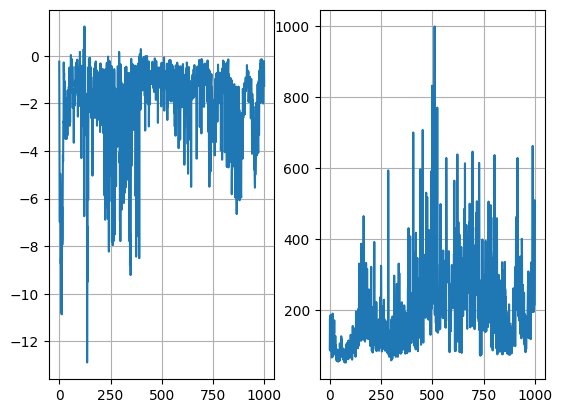

In [7]:
plt.subplot(1,2,1)
plt.plot(rews_log)
plt.grid()
plt.subplot(1,2,2)
plt.plot(steps_log)
plt.grid()
plt.show()

In [8]:
target[:10], Q1(s, a)[:10]

(tensor([ -2.6392,  -1.1777,  -9.4905, -11.9030,  -9.3179, -18.8797,  -0.5739,
          -9.7134,  -4.2801, -61.6988], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([ -2.3352,  -2.2623, -12.3138,  -8.7916, -10.8103, -20.6595,  -1.1636,
         -11.3229,  -6.1520, -58.5169], device='cuda:0',
        grad_fn=<SliceBackward0>))

In [9]:
# # Visualization
# import time
# from IPython.display import display, clear_output

# env = gym.make("CartPole-v1", render_mode="rgb_array")
# obs, _ = env.reset()
# done = False
# steps = 0
# while not done:
#     steps += 1
#     p = policy(torch.tensor(obs).to(device))
#     action = p.sample().detach().item()

#     obs, reward, terminated, truncated, _ = env.step(action)
#     done = terminated or truncated
    
#     ### Uncomment below for rendering (tested in ipynb)
#     # a = env.render()
#     # plt.imshow(a)
#     # plt.axis('off')  # Turn off axis
#     # display(plt.gcf())  # Display the current figure
#     # clear_output(wait=True)  # Clear the previous output
# print(steps)